<div style="text-align:center; font-weight:bold; font-size:35px; line-height:1.0;">EDA: Sell Your House for More </div>

<figure style="margin-top:10px"><img src="https://www.racialequityalliance.org/wp-content/uploads/2016/10/assessors_social-1.jpg" />
<figcaption style="text-align:center; font-size:8px">source: https://www.racialequityalliance.org/jurisdictions/king-county-washington/assessors_social/</figcaption>
</figure>




# Initial Imports and Data Cleaning

## How can we get more money for our house in King County?

We are selling our house and would like to know which characteristics of a home can help improve the sale price.

In order to help answer this question, we have been provided a dataset of home sales in King County which occurred during the period of September 9, 2014 through January 10, 2015.

We will attempt to model sale prices based on the other data fields and then determine which characteristics lead to an increase in sale price.

## Our Dataset

The data was provided in a csv format.  There are 21,597 sales records and 21 columns.

Column Names and descriptions:
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## Import Libraries and Custom Functions

The following code will import our custom functions from Mod1_Functions.py.

We also import pandas, numpy, matplotlib, seaborn, statsmodels, and scikit-learn.

In [1]:

from Mod1_Functions import *


## Import Raw Dataset

We import the csv data into a pandas dataframe by using `pandas.read_csv()`.

In [2]:
df_raw = pd.read_csv('kc_house_data.csv')

The code below shows the count of any data columns that are missing information.

In [3]:
missing = df_raw.shape[0] - df_raw.count()
print(missing[missing>0])

waterfront      2376
view              63
yr_renovated    3842
dtype: int64


From above, we can see that `waterfront`, `view`, and `yr_renovated` are missing values.

`date` is formatted as an object type, instead of a date (datetime64).

`sqft_basement` is also formatted as an object type, when we would expect a number format.

Let's take a look at some scatter plots of each potential X variable compared to our target `'price'`.

The custom function below accepts inputs of a dataframe and the name of the column that is the target.  Additional parameters can also be passed through to adjust the formatting.

Warnings are printed for any variables that cannot immediately be graphed as numbers, due to their datatypes.

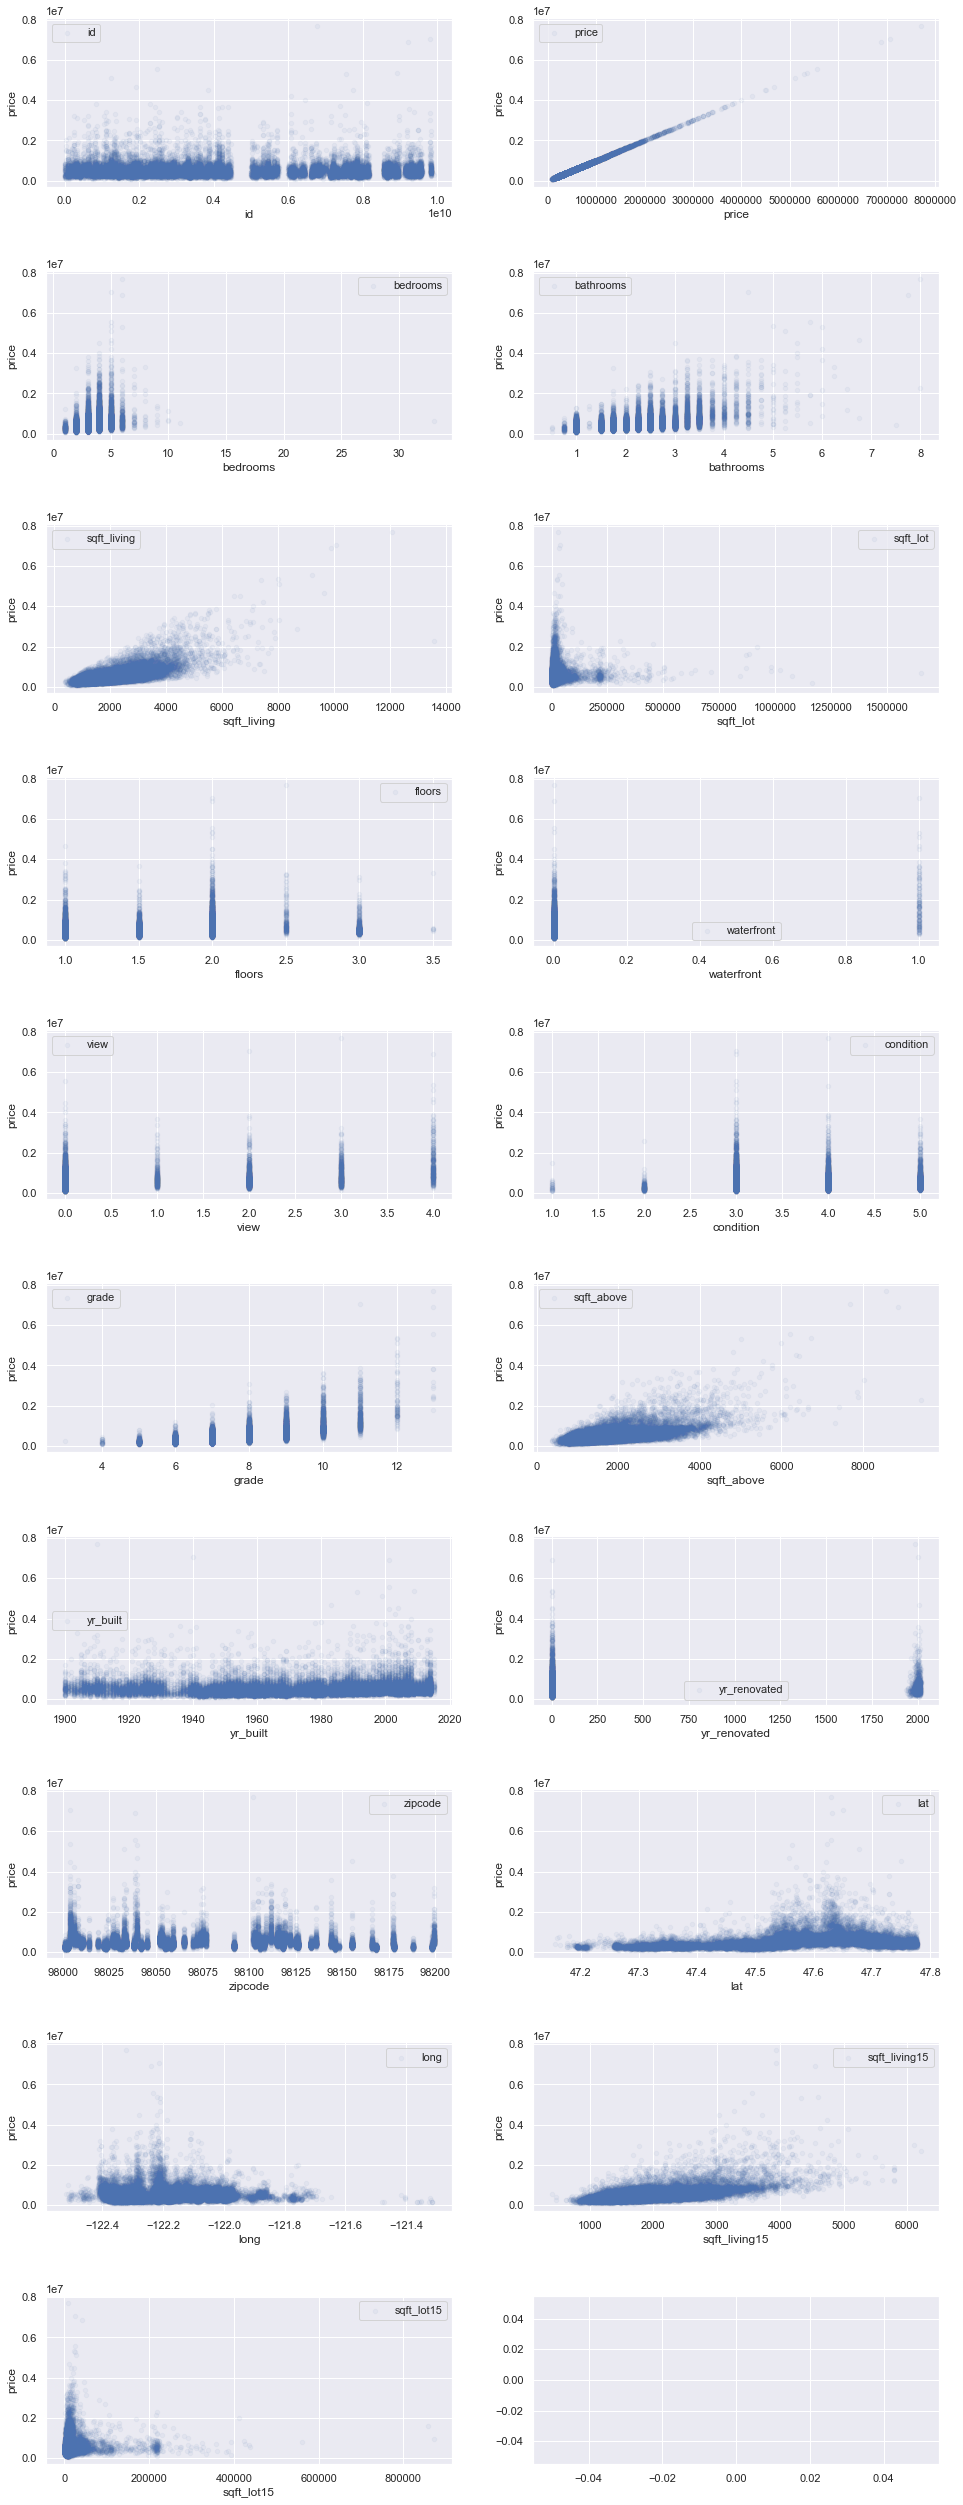

In [4]:
scatter_y(df_raw.drop(['date', 'sqft_basement'], axis=1), 'price', ncols=2, figsize=(16,45))


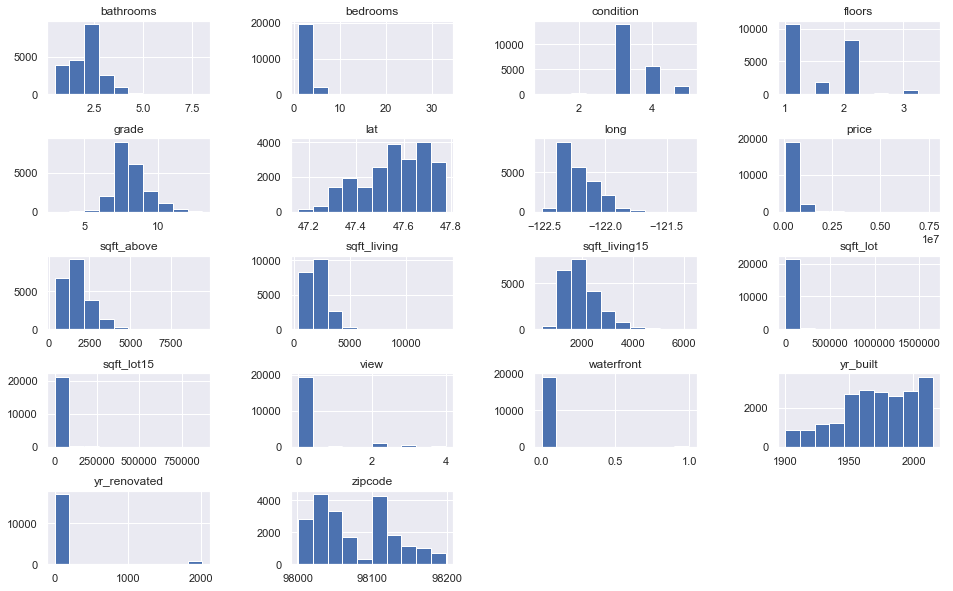

In [5]:
df_raw.iloc[:, 2:].hist(figsize  = [16, 10])
plt.subplots_adjust(wspace=0.5, hspace=0.6)

## Clean data using custom function

Our `clean_dataframe()` function takes in inputs of dataframe and a dictionary of adjustments.

We first set our `data_adjustments` dictionary to contain the fields we want to change as keys and a list of adjustments as dictionary values.

The parameters in the list are: \[datatype, value to replace, value to replace with, replacement array\]

    - datatype: must be a valid data type
    - value to replace: can be a single value string, integer, or np.nan
    - value to replace with: can be a single value or can be a list with strings containg other column names in dataframe (see replacement array below)
    - replacement array: contains a list of floats or integers, which are multiplied by the associated data field in the "value to replace with" list
    
The list items should be set to None for any parameters you do not wish to use.

We found some issues with the following data fields and decided to make some adjustments.

- `'date'` : Currently the date is formatted as a string and we would like to change it into a date (datetime64) so that we can use it in our model.


- `'bedrooms'` : There was one unusually high value of 33 bedrooms for one record.  We decided to replace that value with 3, based on the properties nearest neighbors by `'price'` and `'sqft_living'`.  It is also reasonable to assume that that the 33 was an accidental double-keystroke.


- `'waterfront'`: There were 2,376 missing values in this field, which we have replaced with 'missing'.  We don't know whether these records are on the waterfront or not, but it is a significant enough proportion of records (11%), so we don't want to make an assumption about whether they are on the waterfront and also don't want to exclude them from the dataset.

In [6]:
data_adjustments = {'date': ['datetime64', None, None, None],
                    'bedrooms': [None, 33, 3, None],
                    'waterfront': [str, np.nan, 'missing', None],
                    'view': [str, np.nan, 0, None],
                    'sqft_basement': [float, '?', ['sqft_living', 'sqft_above'], [1, -1]],
                    'floors': [None, 3.5, 3, None]
                   }

In [7]:
df_clean = clean_dataframe(df_raw, data_adjustments)

## Add features calculated from other columns

We wondered whether there was any seasonality to home sale prices, so we needed to extract the month 

We created a `'month'` column in order to calculate a `'season'` column that will be used to categorize by season of the year.

A large proportion of houses do not have basements.  There may be a trend in home prices relative to basement size, specifically for homes that have a basement.  In order to classify those similarly, we have an added dummy variable which equals 1 if there is a basement.

We also create a custom binned variable `'yr_renovated_cat'` which categorizes whether the house has been renovated and whether that renovation was recent.

We have also add a dummy variable that classifies whether the house's square footage above ground is in the top 50% of the data set for square footage above ground.

After some work further on with the model, we determined that there were 4 zip codes where the average sales price was much higher than in other zipcodes.  Rather than consider every zipcode as a dummy variable, we decided to make a single variable for whether or not the property is in one of the 4 high priced zipcodes.

After running the function to create a new dataframe with these variables added, we show the information for each of the columns that have been added.

In [8]:
df_feature_add = add_features_to_df(df_clean)

df_feature_add[list(set(df_feature_add.columns) - set(df_clean.columns))].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 13 columns):
bathroom_bins         21597 non-null int64
yr_renovated_cat      21597 non-null object
date_num              21597 non-null int64
zip_highprice         21597 non-null int64
grade_bin             21597 non-null int64
month                 21597 non-null int64
season                21597 non-null object
startdate             21597 non-null datetime64[ns]
sqft_above_tophalf    21597 non-null int64
has_basement          21597 non-null int64
historic_home         21597 non-null int64
dist_city_center      21597 non-null float64
age                   21597 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(9), object(2)
memory usage: 2.1+ MB


## Target Scaling

Let's take a look at the distribution of prices.

The prices appear to follow a log relationship.

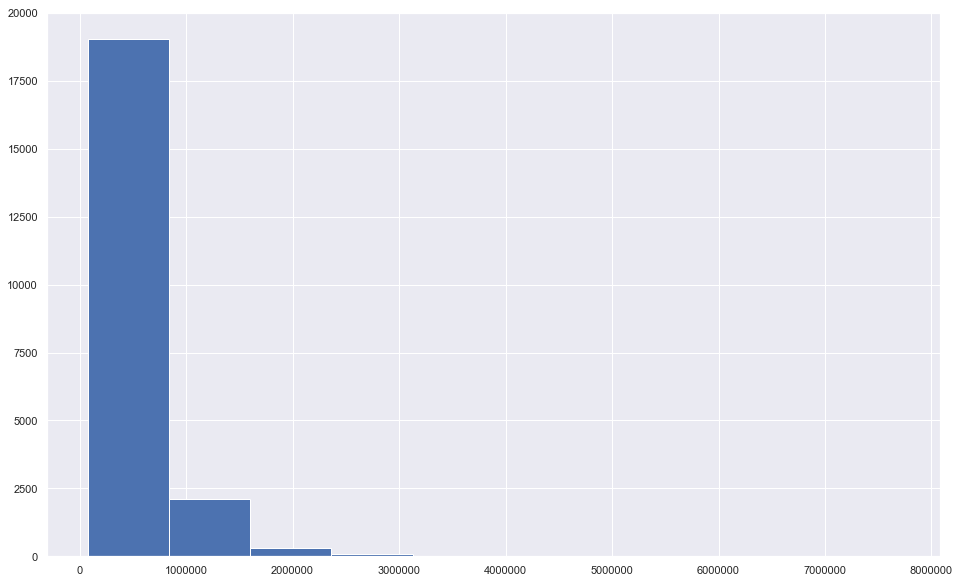

In [9]:
df_feature_add.price.hist(figsize  = [16, 10])

Let's consider evulating a log-linear relationship by adding a `'log_price'` column.

In [10]:
df_feature_add['log_price'] = np.log(df_feature_add['price'])

Taking another look at the distribution of prices after taking the log reveals that we have much closer to a normal distribution of log_price.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


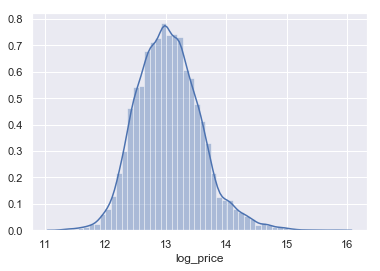

In [11]:
sns.distplot(df_feature_add.log_price);

And take another look at the scatter plots compared to the new target of `'log_price'` 

In [12]:
#scatter_y(df_feature_add, 'log_price', ncols=2, figsize=(16,45))

## Analyze Correlation between our variables

We need evaluate the correlation matrix to determine whether any of our X variables are highly correlated, which would necessitate removing at least one of them to avoid multicolinearity problems.

To make things easier, we have a function that will find any pairs of variables in the matrix with an absolute value of correlation greater than the second parameter (default = 0.75).

In [13]:
corr_pairs = findcorrpairs(df_feature_add, 0.7)
corr_pairs

,Pairs,Correlation
15,"[grade, grade_bin]",1.00
3,"[bathroom_bins, bathrooms]",0.97
1,"[log_price, price]",0.89
7,"[sqft_above, sqft_living]",0.88
22,"[has_basement, sqft_basement]",0.82
20,"[sqft_above, sqft_above_tophalf]",0.79
2,"[bathrooms, sqft_living]",0.76
6,"[grade, sqft_living]",0.76
8,"[sqft_living, sqft_living15]",0.76
10,"[grade_bin, sqft_living]",0.76


# Our Initial Regression Model

## Set-up

From our intuition about the scatter plots above, along with removing a few variables that would be correlated, we take our first shot at linear regression.

Below is our list of initial X variables to try and model upon.

Some intuitive features you would see in the listing for the home include the number of bedrooms and bathrooms and the square footage of the home and property.

In [14]:
x_list = ["bedrooms", 
          "bathrooms", 
          "sqft_above", 
          "sqft_basement", 
          "sqft_lot", 
          "sqft_living15", 
          "sqft_lot15"]

We first run the regression using stats model's OLS function.  Note that the dataframe of X variables must include a column of constants (1).  We have decided to use `'log_price'` as our target (Y).

In [15]:
X = df_feature_add.loc[:, x_list]
X = sm.add_constant(X)
Y = df_feature_add['log_price']

## Initial Model Results

The code below fits our model and sets it equal to the variable `model_init`.  We then take a look at the results with the `.summary()` method

In [16]:
model_init = sm.OLS(Y, X).fit()
model_init.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     3287.
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        09:57:58   Log-Likelihood:                -8957.0
No. Observations:               21597   AIC:                         1.793e+04
Df Residuals:                   21589   BIC:                         1.799e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.1662      0.011   1075.905      0.000      12.144      12.188
bedrooms         -0.0577      0.003    -16.510      0.000      -0.065      -0.051
bathrooms         0.0554      0.005     10.986      0.000       0.046       0.065
sqft_above        0.0003   6.01e-06     47.458      0.000       0.000       0.000
sqft_basement     0.0004   6.99e-06     51.438      0.000       0.000       0.000
sqft_lot       2.408e-07   8.68e-08      2.773      0.006    7.06e-08    4.11e-07
sqft_living15     0.0002   5.73e-06     31.259      0.000       0.000       0.000
sqft_lot15    -1.175e-06   1.33e-07     -8.866      0.000   -1.43e-06   -9.15e-07
==============================================================================
Omnibus:                       25.329   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.437
Skew:                           0.031   Prob(JB):                     1.34e-05
Kurtosis:                       2.855   Cond. No.                     2.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<font size="4">Not great...<br>
    Our correlation of 0.516 isn't very good. <br><br> However, the silver lining is that the distribution of residuals appears to be approximately normally distributed based on the histogram of residuals and Q-Q plot below. </font>

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


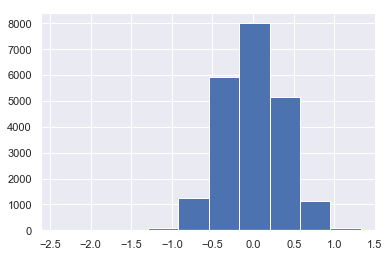

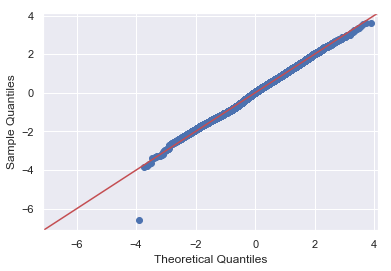

In [17]:
residual_hist_qq(model_init)

# Making our model smarter

## Removing Outliers

We observed that there were some very large outliers in the fields of `'sqft_lot'` and `'sqft_lot15'`.

Our condition below removes any outliers beyond the 99.9th percentile.

The output below the code shows that 38 total outliers were removed.

In [18]:
var_limits = {'sqft_lot': [0, .999], 
              'sqft_lot15': [0, .999]}


df_filter = filter_df_quantiles(df_feature_add, var_limits)


filtered out 0 records with sqft_lot less than: 520.00
filtered out 22 records with sqft_lot greater than: 495972.95
filtered out 0 records with sqft_lot15 less than: 651.00
filtered out 16 records with sqft_lot15 greater than: 303191.60
38 total records removed


## Data Preprocessing

### Categorical Dummy Variables

First we use our `set_to_categorical()` function to take the list of variables shown below and convert each to a category datatype in the dataframe.

We have made a custom function `create_dummyframe()` which generates a data frame of dummy variables for each of the variables listed in the second parameter from the original data frame.

Each of our categorical column groups needs at least one column removed to avoid multicolinearity issues.

### Logarithm of Selected Variables

Based on the scatterplot of possible x variables and `'log_price'` we assess that the following variables should have the log function applied in order for their relationships with `'log_price'` to be linear. 

### Scaling our Variables

To make sure no variables have any added or diminished effect simply due to the magnitude of the variable, we will standardize.

Some variables are standardized using the `MinMaxScaler()`, while others use the `StandardScaler()`.

We defaulted to using the `StandardScaler()` except for those variables that can be represented well by a specific domain.  

In this case, we thought that was appropriate for the `'date_num'`  data field because they can be thought of as positions of dates within a specific range of time.

### Applying these steps using our `preprocess_data()` function

In [104]:
categorical_columns = ['waterfront', 'view', 'condition',
                       'yr_renovated_cat', 'season', 'grade_bin']

log_list = ['sqft_above', 'sqft_basement',
            'sqft_living15', 'sqft_lot']


min_max_list = []


dropout_list = ['price', 'id', 'date', 'bathrooms', 'grade', 'bedrooms', 'yr_built', 'date_num', 'season_Summer', 'season_Winter',
                 'lat', 'long', 'log_price', 'month', 'sqft_above_tophalf', 'floors', 'zipcode', 'sqft_living15',
                'sqft_basement', 'startdate', 'sqft_living', 'age', 'sqft_lot15', 'yr_renovated_cat_Prior to 2000', 'waterfront_missing',
                'yr_renovated', 'yr_renovated_cat_missing']

In [105]:
X_possible = preprocess_data(df_filter, categorical_columns=categorical_columns, log_list=log_list,  min_max_list=min_max_list, dropout_list=dropout_list)
Y = df_filter['log_price']

Categorical Variables:
waterfront          category
view                category
condition           category
season              category
yr_renovated_cat    category
grade_bin           category
dtype: object


To avoid multicollinearity, the following datafields were dropped: waterfront_0.0, view_0.0, condition_1, season_Fall, yr_renovated_cat_Never Renovated, grade_bin_5


Converted the following datafields to natural log: sqft_above, sqft_basement, sqft_living15, sqft_lot


No variables scaled with min-max scaler


No variables scaled with standard scaler


Dropped price from the output dataset
Dropped id from the output dataset
Dropped date from the output dataset
Dropped bathrooms from the output dataset
Dropped grade from the output dataset
Dropped bedrooms from the output dataset
Dropped yr_built from the output dataset
Dropped date_num from the output dataset
Dropped season_Summer from the output dataset
Dropped season_Winter from the output dataset
Dropped lat from the outpu

## Plug in our Scaled and Adjusted Variables to the Model

In [106]:
X_model = sm.add_constant(X_possible)

We will split up our data so that we can train on one set of data and test it against the other set.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_model, Y, test_size = 0.2)

In [108]:
model_smarter = sm.OLS(y_train, X_train).fit()
model_smarter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     2285.
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        13:02:34   Log-Likelihood:                -1061.8
No. Observations:               17247   AIC:                             2174.
Df Residuals:                   17222   BIC:                             2367.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     8.8688      0.082    108.556      0.000       8.709       9.029
sqft_lot                                  0.0698      0.003     25.321      0.000       0.064       0.075
sqft_above                                0.4150      0.009     44.460      0.000       0.397       0.433
has_basement                              0.1181      0.005     23.442      0.000       0.108       0.128
zip_highprice                             0.3291      0.010     31.932      0.000       0.309       0.349
dist_city_center                         -0.0191      0.000    -81.236      0.000      -0.020      -0.019
bathroom_bins                             0.0370      0.004     10.350      0.000       0.030       0.044
historic_home                             0.1483      0.007     22.805      0.000       0.136       0.161
waterfront_1.0                            0.3215      0.030     10.669      0.000       0.262       0.381
view_1.0                                  0.1094      0.016      6.749      0.000       0.078       0.141
view_2.0                                  0.1006      0.010     10.345      0.000       0.082       0.120
view_3.0                                  0.1890      0.013     14.154      0.000       0.163       0.215
view_4.0                                  0.3231      0.020     15.885      0.000       0.283       0.363
condition_2                               0.0591      0.060      0.980      0.327      -0.059       0.177
condition_3                               0.2430      0.057      4.290      0.000       0.132       0.354
condition_4                               0.2894      0.057      5.108      0.000       0.178       0.400
condition_5                               0.3665      0.057      6.439      0.000       0.255       0.478
yr_renovated_cat_Since 2000 inclusive     0.1073      0.015      7.029      0.000       0.077       0.137
season_Spring                             0.0423      0.004      9.893      0.000       0.034       0.051
grade_bin_6                               0.0826      0.019      4.380      0.000       0.046       0.120
grade_bin_7                               0.2631      0.019     14.126      0.000       0.227       0.300
grade_bin_8                               0.4223      0.020     21.641      0.000       0.384       0.461
grade_bin_9                               0.6061      0.021     29.091      0.000       0.565       0.647
grade_bin_10                              0.7421      0.023     32.787      0.000       0.698       0.786
grade_bin_11                              0.9067      0.026     35.220      0.000       0.856       0.957
==============================================================================
Omnibus:                      283.90

<font size="4"> $r^{2}$ has improved since our initial model.  It's not too bad at about 0.75.<br><br> But we need to do a few more tests before we can feel good about it.  So far, all we know is that this model can do a decent job at predicting prices for the houses in the training data.</font> 

## Testing against our Test Data

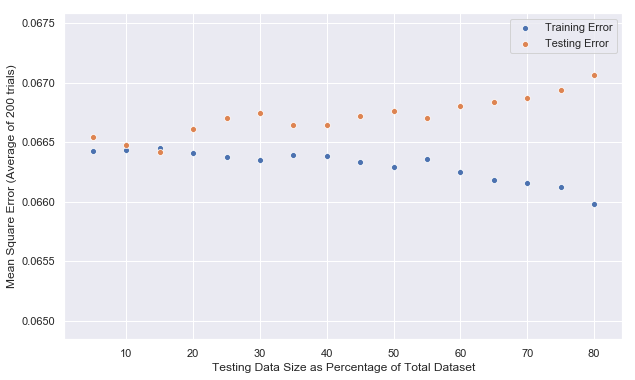

In [109]:
plot_mse_train_test(X_model, Y, start_test_pct=5, test_pct_inc=5, end_test_pct=82, num_iter=200)


# K-Fold Cross Validation

In [110]:
linreg = LinearRegression()

model_kfold = KFold(n_splits=10, shuffle=True)

MSEs = cross_val_score(linreg, X_model, Y, scoring='neg_mean_squared_error', cv=model_kfold)

mean_MSE = np.mean(MSEs)

print(mean_MSE)
print(MSEs)

-0.0666058265844918
[-0.06939542 -0.06595167 -0.06858029 -0.06384573 -0.06661092 -0.06416683
 -0.06549593 -0.06550961 -0.07092201 -0.06557986]


# Selecting our Most Significant Variables using Recursive Feature Elimination

<font size="3"> Our first function loops uses recursive feature elimination to generate models with different numbers of variables, ranging from 1 to all 34. <br> 
We then plot the values of $r^{2}$  and mean squared error against the number of variables.
</font>

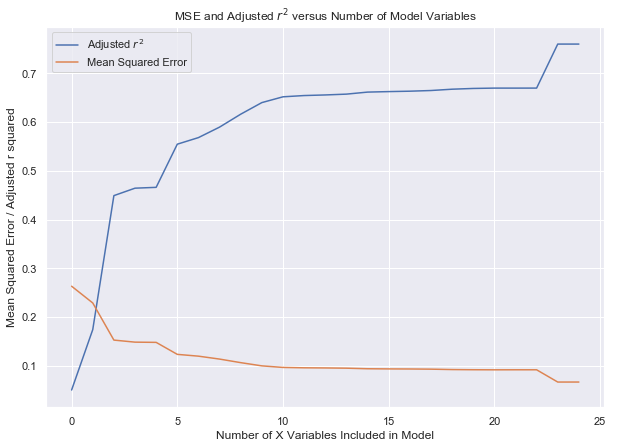

In [111]:
plot_RFE_var_iter(X_model, Y, k_fold_n_splits=5, shuffle=True, scoring='neg_mean_squared_error')

In [120]:
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 24)
selector = selector.fit(X_model, Y.squeeze())
selected_X = X_model.columns[selector.support_]

df_selected = X_model.loc[:, selected_X]
df_selected = sm.add_constant(df_selected)

model_RFE = sm.OLS(Y, df_selected).fit()
model_RFE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     2846.
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        13:12:00   Log-Likelihood:                -1360.5
No. Observations:               21559   AIC:                             2771.
Df Residuals:                   21534   BIC:                             2971.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     8.8683      0.071    124.451      0.000       8.729       9.008
sqft_lot                                  0.0689      0.002     27.912      0.000       0.064       0.074
sqft_above                                0.4142      0.008     49.783      0.000       0.398       0.431
has_basement                              0.1195      0.005     26.457      0.000       0.111       0.128
zip_highprice                             0.3328      0.009     36.140      0.000       0.315       0.351
dist_city_center                         -0.0188      0.000    -90.028      0.000      -0.019      -0.018
bathroom_bins                             0.0382      0.003     11.965      0.000       0.032       0.044
historic_home                             0.1507      0.006     25.801      0.000       0.139       0.162
waterfront_1.0                            0.3384      0.026     12.896      0.000       0.287       0.390
view_1.0                                  0.1146      0.014      7.929      0.000       0.086       0.143
view_2.0                                  0.1074      0.009     12.287      0.000       0.090       0.125
view_3.0                                  0.1731      0.012     14.488      0.000       0.150       0.197
view_4.0                                  0.3172      0.018     17.525      0.000       0.282       0.353
condition_2                               0.0761      0.052      1.462      0.144      -0.026       0.178
condition_3                               0.2570      0.048      5.311      0.000       0.162       0.352
condition_4                               0.3019      0.048      6.237      0.000       0.207       0.397
condition_5                               0.3803      0.049      7.815      0.000       0.285       0.476
yr_renovated_cat_Since 2000 inclusive     0.1044      0.014      7.680      0.000       0.078       0.131
season_Spring                             0.0444      0.004     11.582      0.000       0.037       0.052
grade_bin_6                               0.0731      0.017      4.290      0.000       0.040       0.106
grade_bin_7                               0.2548      0.017     15.177      0.000       0.222       0.288
grade_bin_8                               0.4164      0.018     23.710      0.000       0.382       0.451
grade_bin_9                               0.5967      0.019     31.861      0.000       0.560       0.633
grade_bin_10                              0.7300      0.020     36.000      0.000       0.690       0.770
grade_bin_11                              0.8960      0.023     38.790      0.000       0.851       0.941
==============================================================================
Omnibus:                      345.53

Once again, we want to check our distribution of errors and the comparison of the actual quantiles versus theoretical in the Q-Q plot

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


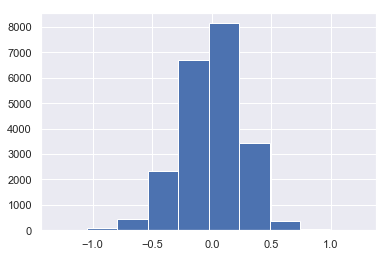

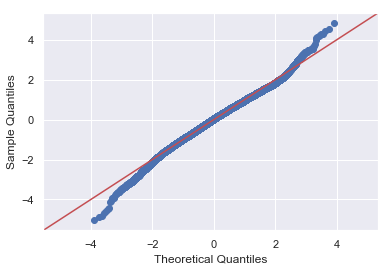

In [121]:
residual_hist_qq(model_RFE)

Our model fitted to the target of `'log_price'`.  In order to compare how closely we matched to the actual price, we will need to take the exponential of both the actual `Y['log_price']` and the predicted values of `'log_price'`.

The graphs below shows how the actual prices compare to the predicted prices in our data.  We would hope the reuslts would be relatively close to the line drawn by y=x.

We can also graph our residuals, which is essentially a shift of the first graph so that the line y=x essentially becomes the x-axis.

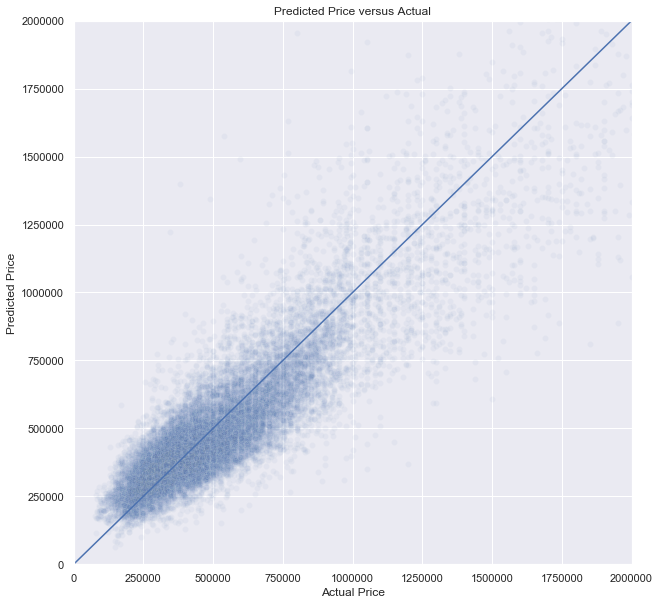

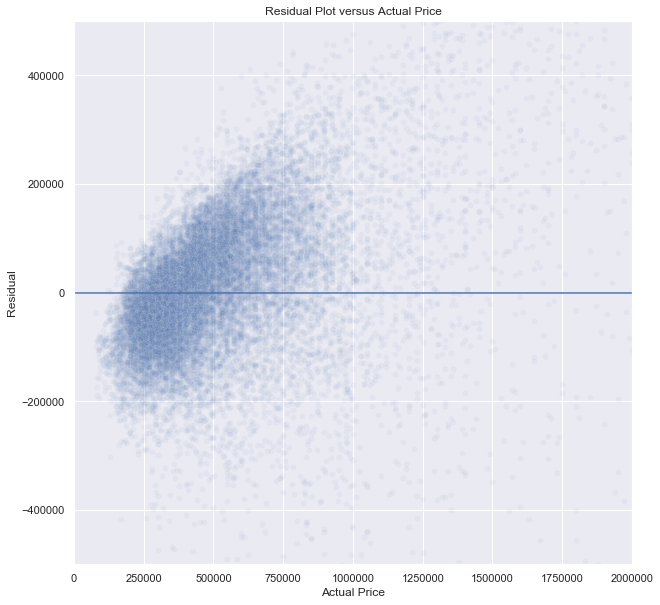

In [122]:
y_hat_exp = np.exp(model_RFE.predict(df_selected))
y_exp = np.exp(Y.squeeze())

plt.figure(figsize=(10,10))
sns.scatterplot(y_exp, y_hat_exp, alpha=0.05)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
limiter = 2000000
plt.xlim(0, limiter)
plt.ylim(0, limiter)
plt.title('Predicted Price versus Actual')
sns.lineplot(x=[0, limiter], y=[0, limiter]);
plt.show()


plt.figure(figsize=(10,10))
sns.scatterplot(y_exp, y_exp - y_hat_exp, alpha=0.05)
plt.xlabel('Actual Price')
plt.ylabel('Residual')
plt.xlim(0,limiter)
plt.ylim(-500000,500000)
plt.title('Residual Plot versus Actual Price')
sns.lineplot(x=[0,6000000], y=[0, 0]);

In [123]:
print('Average Absolute Error: ${0:.2f}'.format(np.mean(abs(y_exp - y_hat_exp))))
print('Average Percent Error: {0:.2f}%'.format(100 * np.mean(abs(y_exp - y_hat_exp)) / y_exp.mean()))
print('Average of Absolute Error for each: {0:.2f}%'.format(100*np.mean(abs(y_exp - y_hat_exp)/y_exp)))

Average Absolute Error: $104988.15
Average Percent Error: 19.44%
Average of Absolute Error for each: 21.00%


# Interpretation


In [124]:
pd.set_option('display.max_colwidth', -1)
interpret_coef(model_RFE, df_filter, log_list=log_list, min_max_list=min_max_list, categorical_columns=categorical_columns)

,variable,coef,interpretation
0,sqft_lot,0.068950,Price is expected to increase by 0.0689% for each 1% increase in sqft_lot
1,sqft_above,0.414234,Price is expected to increase by 0.4142% for each 1% increase in sqft_above
2,has_basement,0.119484,Price is expected to increase by 12.6915% for each unit increment in has_basement
3,zip_highprice,0.332802,Price is expected to increase by 39.4871% for each unit increment in zip_highprice
4,dist_city_center,-0.018837,Price is expected to increase by -1.8661% for each unit increment in dist_city_center
5,bathroom_bins,0.038189,Price is expected to increase by 3.8927% for each unit increment in bathroom_bins
6,historic_home,0.150706,Price is expected to increase by 16.2655% for each unit increment in historic_home
7,waterfront_1.0,0.338358,Price is expected to increase by 40.2643% if condition met for waterfront_1.0
8,view_1.0,0.114634,Price is expected to increase by 12.1463% if condition met for view_1.0
9,view_2.0,0.107435,Price is expected to increase by 11.3419% if condition met for view_2.0


In [127]:
X_model.sqft_above.median()

7.352441100243583

In [128]:
Y.median()

13.017002861746503

In [130]:
144/np.exp(X_model.sqft_above.median())

0.09230769230769229

In [131]:
np.exp(Y.mean())*(0.4142*(144/np.exp(X_model.sqft_above.median())))

17742.956507126964

In [135]:
df_raw.condition.value_counts()

3    14020
4    5677 
5    1701 
2    170  
1    29   
Name: condition, dtype: int64